In [1]:
import BenchmarkTools: @btime, @benchmark;

import Pkg: activate, build
activate("../GSHEIntegrator/.")
import GSHEIntegrator;


import Plots
using LaTeXStrings
using Measures
using NPZ
using EllipsisNotation

  Activating project at `~/Projects/birefringence/GSHEIntegrator`


# 1. Extreme case

In [2]:
runID = "13"

ϵs = npzread("../results/run_$runID/Epsilons.npy")
rsource = 10.0
θsource = 0.5π
ϕsource = 0.0

robs = 100.0
θobs = 0.4π
ϕobs = π


as = 0.99

postproc_options = GSHEIntegrator.PostprocOptions(check_sols=true)
ode_options = GSHEIntegrator.ODESolverOptions(Δθ=0.00001, horizon_tol=1.0001, no_loops=false, maxiters=10000)
opt_options = GSHEIntegrator.OptimiserOptions(Nconsec=20)


geometry = GSHEIntegrator.setup_geometry(Float64;
   rsource=rsource, θsource=θsource, ϕsource=ϕsource,
   robs=robs, θobs=θobs, ϕobs=ϕobs, a=as, s=2, postproc_options=postproc_options, ode_options=ode_options);

211


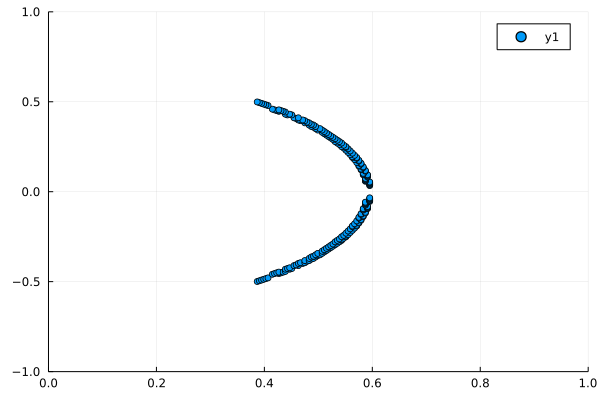

In [3]:
Xgeos = npzread("../results/run_$runID/Xgeos.npy")
Xgshes = npzread("../results/run_$runID/Xgshes.npy")
αs = npzread("../results/run_$runID/alphas.npy")
βs = npzread("../results/run_$runID/betas.npy");
kx = npzread("../results/run_$runID/dir1.npy");
ky = npzread("../results/run_$runID/dir2.npy");

dirs = GSHEIntegrator.make_2dmesh(kx, ky)


m1 = sqrt.(reshape(mapslices(sum, dirs.^2, dims=2), size(dirs,1 ))) .< 1
m2 = (dirs[:, 2] .> 0.3) .&& (dirs[:, 2] .< 0.8)
m3 = .~isnan.(βs[:, 1])
m4 = abs.((βs[:, 1] .- 2)) .< 0.5
# m4 = true
# m4 = βs[:, 1] .> 2
m5 = abs.(dirs[:, 1]) .< 0.5
# m6 = Xgshes[:, end, 6] .> 0
m6 = true

m = m1 .&& m2 .&& m3 .&& m4 .&& m5 .&& m6

println(sum(m))

ps = [i for i in 1:size(dirs, 1) if m[i]]

Plots.scatter(dirs[m, 2], dirs[m, 1], xlim=(0,1), ylim=(-1,1))

αs = [2.0029150917881626, 0.0004328148742362841]
βs = [2.0163304589029036, 0.005801816328965399]


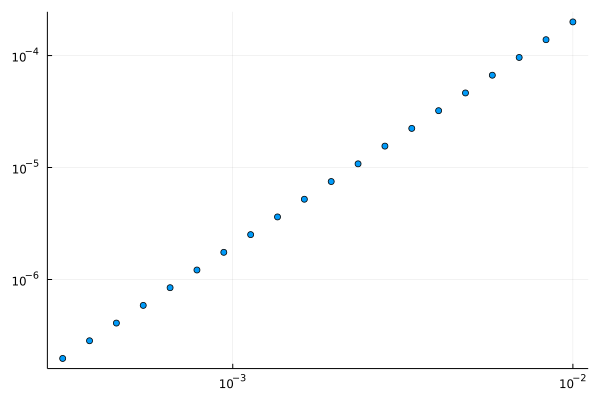

[0.9960350041670459, 3.444678350391178, 120.29269670850995, 1.1067971810777715, 1.3412925459203609e-14, 0.0, 5.2481736948884565, 5.0]


In [7]:
# GSHEIntegrator.shuffle!(ps)
# i = ps[1]

i = 150890
# i = 211
# println(i)
println("αs = $(αs[i, :])")
println("βs = $(βs[i, :])")

Xgshe = Xgshes[i, ..]
Xgeo = Xgeos[i, ..]
println(Xgeo)

ϵs = npzread("../results/run_$runID/Epsilons.npy")

dt = abs.(Xgshes[i, :, 3] .- Xgeos[i, 3])
fig = Plots.scatter(ϵs, dt, yscale=:log10, xscale=:log10, legend=nothing)

# Plots.savefig(fig, "~/Downloads/dts.png")

display(fig)

In [8]:
dir = dirs[i, :]
ϵs = (10).^(LinRange(-3, -2, 30))

X0 = GSHEIntegrator.time_initial!(dir, ϵs[end], 2, geometry, true)
Xgeo, Xgshe = GSHEIntegrator.time_gshe(X0, geometry, ϵs, 2, false)

sol = GSHEIntegrator.solve_problem(Xgshe[end, 1:2], geometry, ϵs[end], 2)
geometry.observer.θ = sol[3, 2]
geometry.observer.ϕ = sol[4, 2]

3.33%, ϵ=1.00e-02 6.67%, ϵ=9.24e-03 10.00%, ϵ=8.53e-03 13.33%, ϵ=7.88e-03 16.67%, ϵ=7.28e-03 20.00%, ϵ=6.72e-03 23.33%, ϵ=6.21e-03 26.67%, ϵ=5.74e-03 30.00%, ϵ=5.30e-03 33.33%, ϵ=4.89e-03 36.67%, ϵ=4.52e-03 40.00%, ϵ=4.18e-03 43.33%, ϵ=3.86e-03 46.67%, ϵ=3.56e-03 50.00%, ϵ=3.29e-03 53.33%, ϵ=3.04e-03 56.67%, ϵ=2.81e-03 60.00%, ϵ=2.59e-03 63.33%, ϵ=2.40e-03 66.67%, ϵ=2.21e-03 70.00%, ϵ=2.04e-03 73.33%, ϵ=1.89e-03 76.67%, ϵ=1.74e-03 80.00%, ϵ=1.61e-03 83.33%, ϵ=1.49e-03 86.67%, ϵ=1.37e-03 90.00%, ϵ=1.27e-03 93.33%, ϵ=1.17e-03 96.67%, ϵ=1.08e-03 100.00%, ϵ=1.00e-03 

3.284396882077094

In [9]:
αs, βs = GSHEIntegrator.fit_Δts(ϵs, Xgshe, Xgeo, geometry)

Dict{String, Vector{Float64}} with 2 entries:
  "alpha" => [2.00443, 0.000350553]
  "beta"  => [2.03312, 0.00422381]

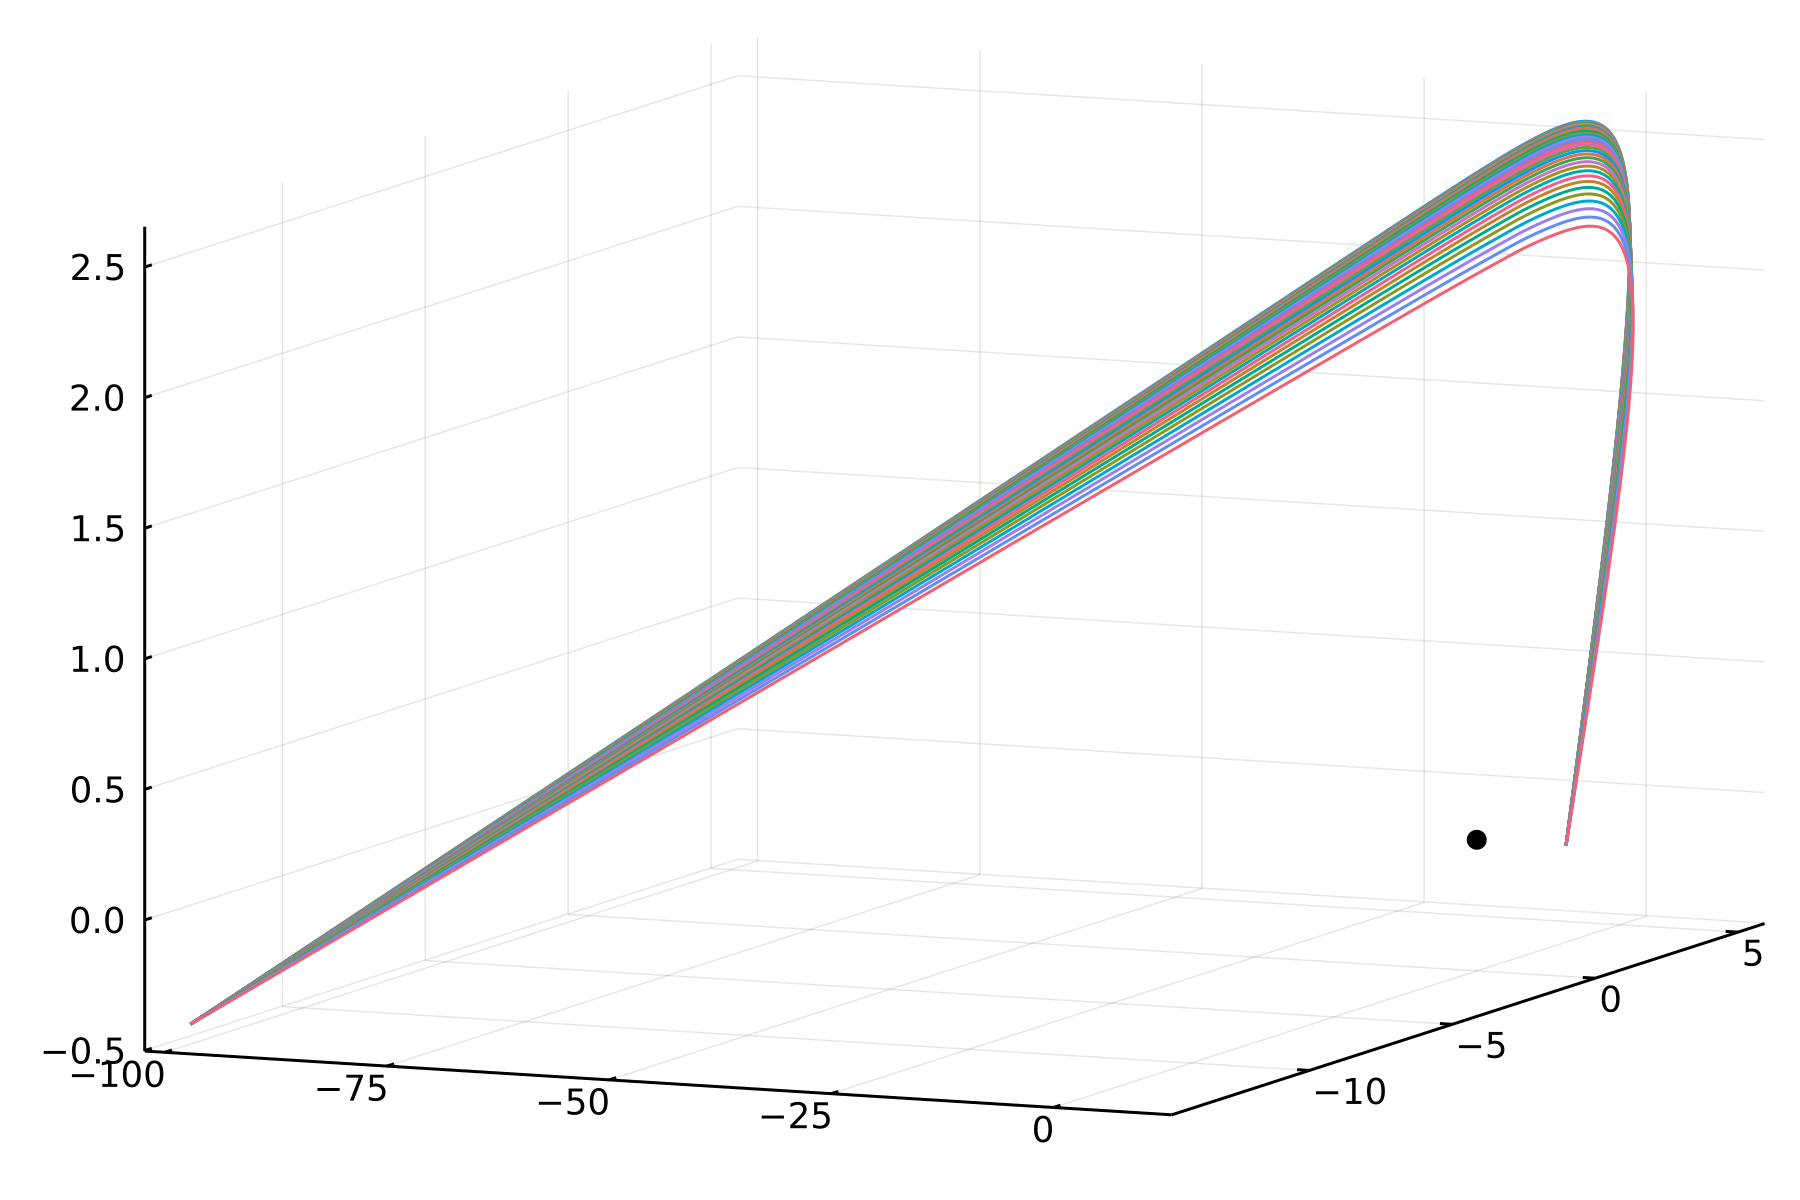

In [11]:
transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)
# fig = Plots.plot(xlim=(-5, 5), ylim=(-2,3), zlim=(-3,3), legend=nothing, dpi=300)
fig = Plots.plot(legend=nothing, dpi=300)
# fig = Plots.plot(legend=nothing, dpi=300)

for j in 1:size(Xgshe, 1)
    if any(isnan.(Xgshe[j, 1:2]))
        continue
    end
    sol = GSHEIntegrator.solve_problem(
        Xgshe[j, 1:2], geometry, ϵs[j], 2; save_everystep=true)
    tr = mapslices(transform, sol[2:4, :], dims=1)
    Plots.plot!(fig, [tr[i, :] for i in 1:3]...)
    # @show maximum(sol[3, :]) ./ π
    # Plots.plot!(sol[1, :], sol[3, :] ./π )
end
Plots.scatter!(fig, (0, 0, 0), c="black", label="Black hole")

# Plots.savefig(fig, "~/Downloads/sol.png")
display(fig)



In [19]:
ϵs = (10).^(LinRange(-3, -1.5, 100))

postproc_options = GSHEIntegrator.PostprocOptions(check_sols=true)
ode_options = GSHEIntegrator.ODESolverOptions(Δθ=0.00001, horizon_tol=1.0001, no_loops=true, maxiters=10000)
opt_options = GSHEIntegrator.OptimiserOptions(Nconsec=20)

geometry_new = GSHEIntegrator.setup_geometry(Float64;
   rsource=geometry.source.r, θsource=geometry.source.θ, ϕsource=geometry.source.ϕ,
   robs=geometry.observer.r, θobs=geometry.observer.θ , ϕobs=geometry.observer.ϕ, a=geometry.a, s=2, postproc_options=postproc_options, ode_options=ode_options);

In [20]:
geometry_new.getmagnification = true

true

In [21]:
Xgeo, Xgshe = GSHEIntegrator.solve_full(geometry_new, ϵs, true, 2)

n = 1
1.00%, ϵ=1.00e-03 2.00%, ϵ=1.04e-03 3.00%, ϵ=1.07e-03 4.00%, ϵ=1.11e-03 5.00%, ϵ=1.15e-03 6.00%, ϵ=1.19e-03 7.00%, ϵ=1.23e-03 8.00%, ϵ=1.28e-03 9.00%, ϵ=1.32e-03 10.00%, ϵ=1.37e-03 11.00%, ϵ=1.42e-03 12.00%, ϵ=1.47e-03 13.00%, ϵ=1.52e-03 14.00%, ϵ=1.57e-03 15.00%, ϵ=1.63e-03 16.00%, ϵ=1.69e-03 17.00%, ϵ=1.75e-03 18.00%, ϵ=1.81e-03 19.00%, ϵ=1.87e-03 20.00%, ϵ=1.94e-03 21.00%, ϵ=2.01e-03 22.00%, ϵ=2.08e-03 23.00%, ϵ=2.15e-03 24.00%, ϵ=2.23e-03 25.00%, ϵ=2.31e-03 26.00%, ϵ=2.39e-03 27.00%, ϵ=2.48e-03 28.00%, ϵ=2.57e-03 29.00%, ϵ=2.66e-03 30.00%, ϵ=2.75e-03 31.00%, ϵ=2.85e-03 32.00%, ϵ=2.95e-03 33.00%, ϵ=3.05e-03 34.00%, ϵ=3.16e-03 35.00%, ϵ=3.27e-03 36.00%, ϵ=3.39e-03 37.00%, ϵ=3.51e-03 38.00%, ϵ=3.64e-03 39.00%, ϵ=3.76e-03 40.00%, ϵ=3.90e-03 41.00%, ϵ=4.04e-03 42.00%, ϵ=4.18e-03 43.00%, ϵ=4.33e-03 44.00%, ϵ=4.48e-03 45.00%, ϵ=4.64e-03 46.00%, ϵ=4.81e-03 47.00%, ϵ=4.98e-03 48.00%, ϵ=5.15e-03 49.00%, ϵ=5.34e-03 50.00%, ϵ=5.53e-03 51.00%, ϵ=5.72e-03 52.00%, ϵ=5.93e-03 53.00%, ϵ=6.14e

([0.9960350046117628 3.4446783514908126 … 1.0 -18.971760495688283; 2.408565199459303 2.8461486005399426 … 1.0 14.932204784300154], [0.9940459935886654 0.9980524140409565; 2.407007741936872 2.410096584585567;;; 0.9939759027764802 0.9981245571619822; 2.406951968786925 2.410150473542734;;; 0.9939033616452084 0.9981992989197078; 2.4068941809875732 2.4102062409807443;;; … ;;; 0.9507421608233856 1.0663527797442167; 2.351982100625273 2.442335297415269;;; 0.9497011144858497 1.0692270669632902; 2.3495757297313915 2.4430823354801543;;; 0.9486689451145728 1.0722285913465264; 2.3470555289977804 2.4438216673454694;;;; 3.4396796623321197 3.449644013254635; 2.8411503846186803 2.8511712830788527;;; 3.4395015845145873 3.449819704326647; 2.8409733822921934 2.8513500535075664;;; 3.4393171404171796 3.4500015891972344; 2.8407901284432917 2.851535203225782;;; … ;;; 3.283526082625007 3.5775977158577947; 2.709359416010746 3.0038834183068412;;; 3.2773007852207163 3.5818211148041885; 2.704913778081859 3.0098171

In [22]:
Δt = GSHEIntegrator.fit_Δts(ϵs, Xgshe, Xgeo, geometry)
# npzwrite(joinpath("../results/", "letter_eps.npy"), ϵs)
# npzwrite(joinpath("../results/", "letter_Xgeo.npy"), Xgeo)
# npzwrite(joinpath("../results/", "letter_Xgshe.npy"), Xgshe)

2-element Vector{Any}:
 [Dict("alpha" => [2.0099184968795303, 0.0006242730500383916], "beta" => [2.10019141749162, 0.007213807853658656]), Dict("alpha" => [1.9928565204611524, 0.00032207429736409433], "beta" => [1.8839978561506276, 0.003256308101781827])]
 [Dict("alpha" => [2.0032949229503214, 0.0002849204652312267], "beta" => [1.6903468388735485, 0.002706702751214494]), Dict("alpha" => [2.000020725583382, 9.479782564403995e-5], "beta" => [1.6555117374797361, 0.0009061092349519127])]

In [23]:
1 / abs(Xgeo[1, 9] / Xgeo[2, 9])^0.5

0.887172664665709

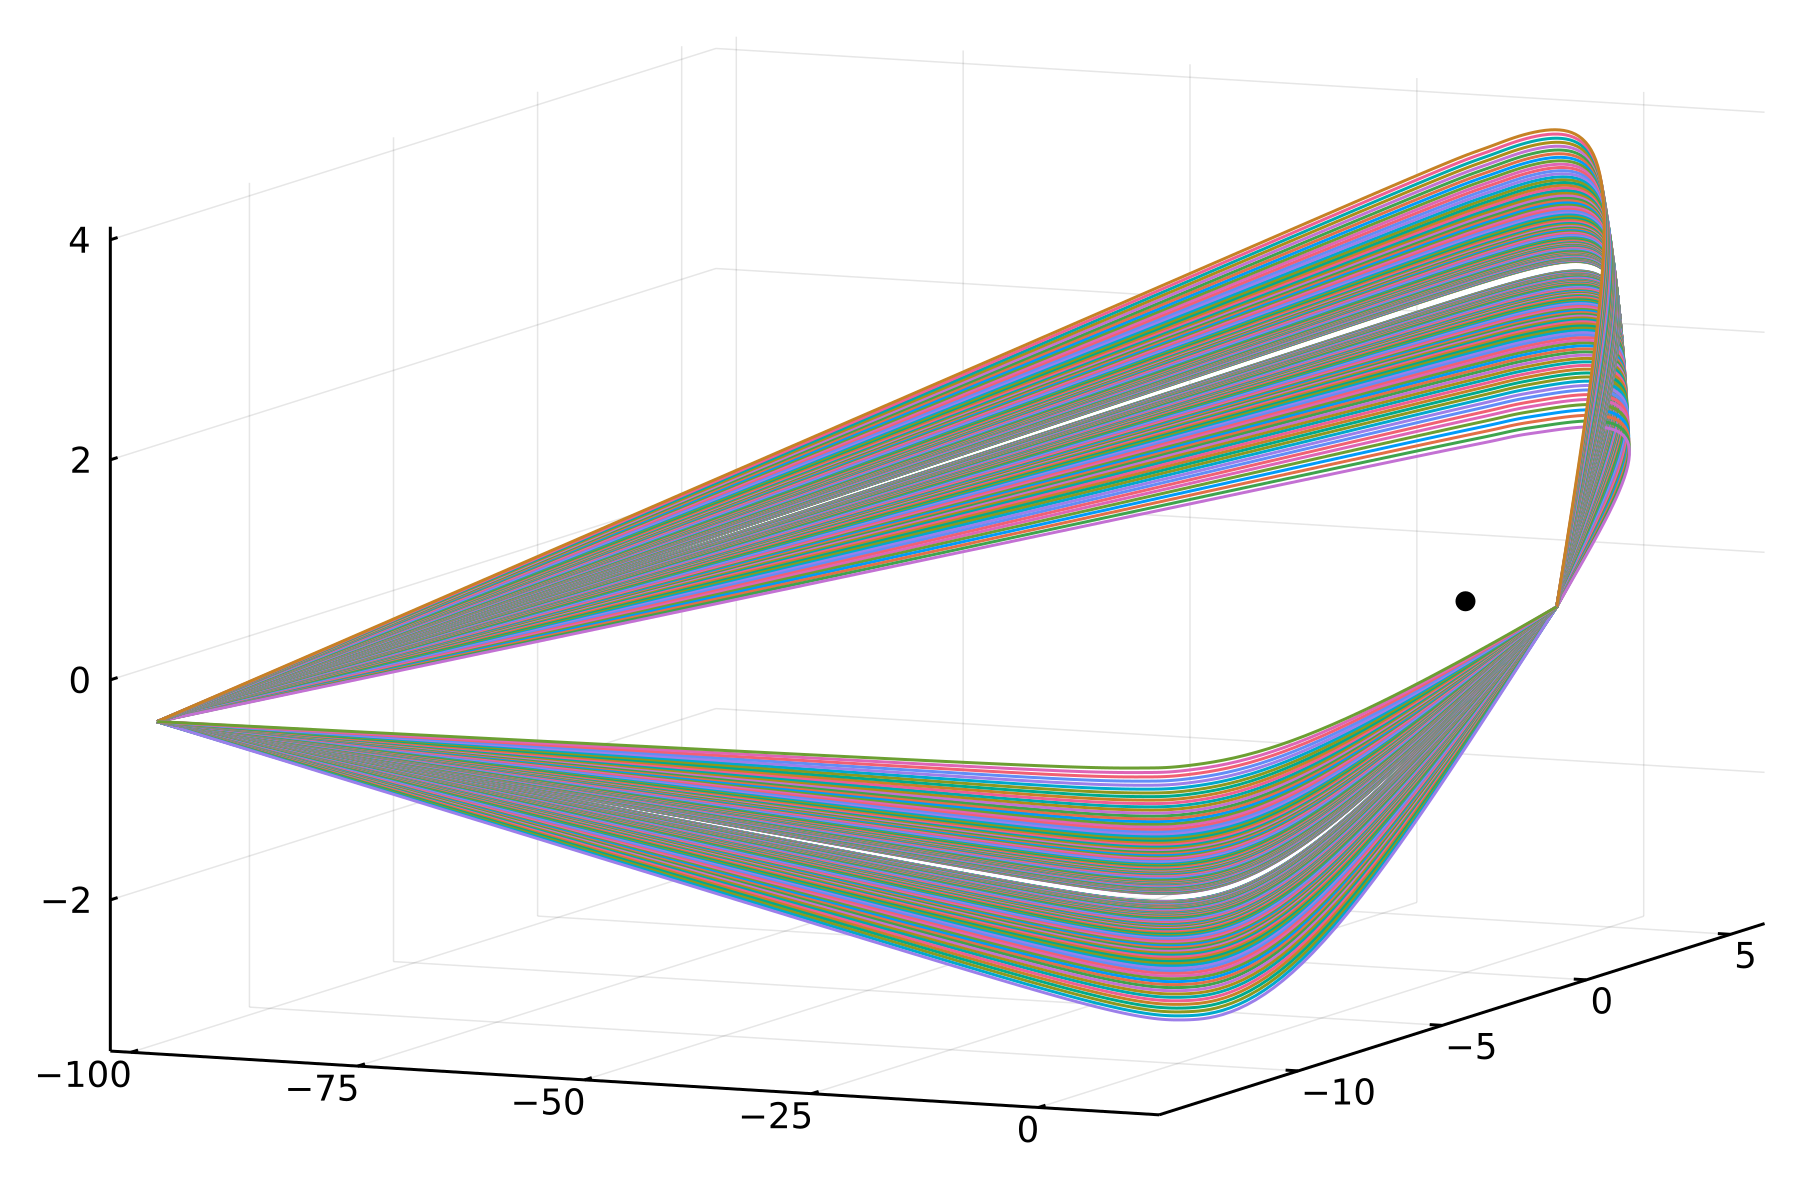

In [24]:
transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)
# fig = Plots.plot(xlim=(-5, 5), ylim=(-2,3), zlim=(-3,3), legend=nothing, dpi=300)
fig = Plots.plot(legend=nothing, dpi=300)



τGSHE = zeros(2, 2, length(ϵs))

for i in 1:2, s in 1:2, j in 1:size(Xgshe, 3)
    if any(isnan.(Xgshe[i, s, j, 1:2]))
        println("Skipping")
        continue
    end
#    println(ϵs[j])
    sol = GSHEIntegrator.solve_problem(
        Xgshe[i, s, j, 1:2], geometry, ϵs[j], s == 1 ? 2 : -2; save_everystep=true)
    τGSHE[i, s, j] = sol.t[end]
    tr = mapslices(transform, sol[2:4, :], dims=1)
    Plots.plot!(fig, [tr[i, :] for i in 1:3]...)
    # @show maximum(sol[3, :]) ./ π
    # Plots.plot!(sol[1, :], sol[3, :] ./π )
end
Plots.scatter!(fig, (0, 0, 0), c="black", label="Black hole")

Plots.savefig(fig, "~/Downloads/sol.png")
display(fig)


τgeo = zeros(2)

for i in 1:2
    sol = GSHEIntegrator.solve_problem(
        Xgeo[i, 1:2], geometry, 0, 0; save_everystep=true)
    τgeo[i] = sol.t[end]
end


In [33]:
size(Xgeo), size(Xgshe)

((2, 9), (2, 2, 100, 9))

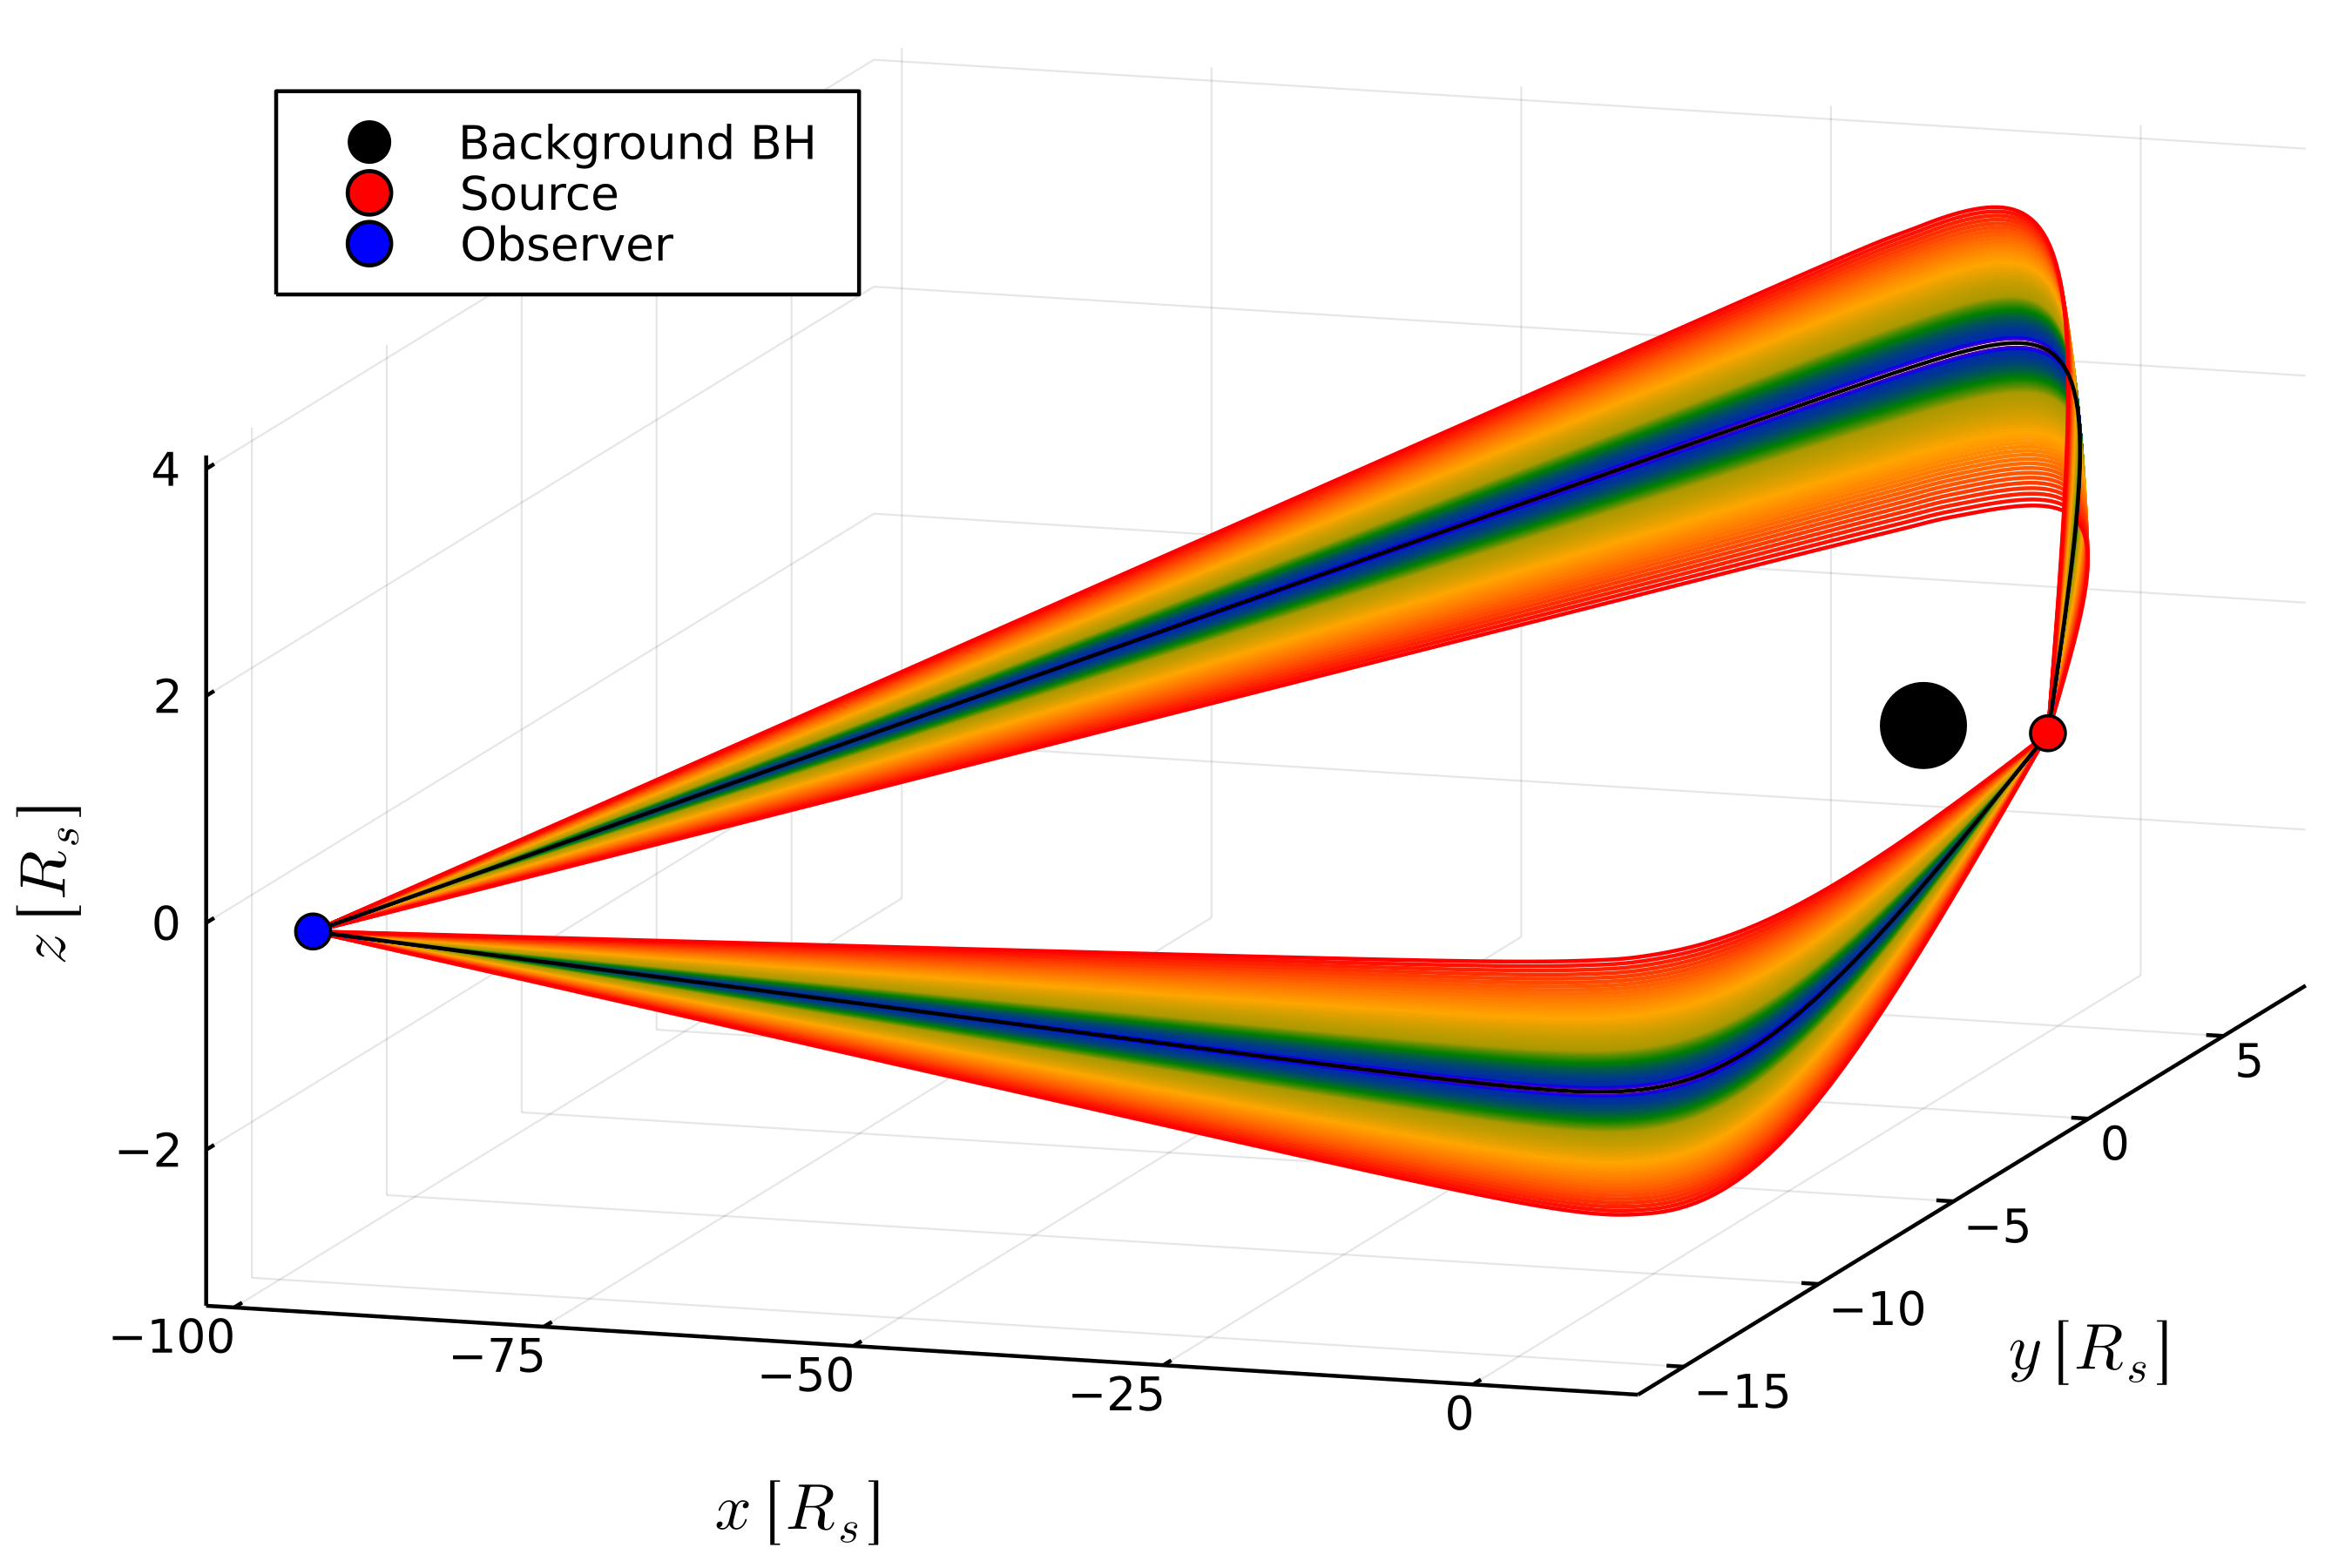

In [78]:
cols = [Plots.cgrad(:rainbow, [minimum(ϵs), maximum(ϵs)], scale=:log)[1000^z] for z in range(-1, 0, length = length(ϵs))]
transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)

fig = Plots.plot(dpi=450, figsize=(3.45*2, 3.45*0.75),
                 xlabel=L"x~[R_{\rm s}]", ylabel=L"y~[R_{\rm s}]", zlabel=L"z~[R_{\rm s}]", legend=:topleft,
                 grid=true, aspect_ratio=3, camera=(25,45))

for i in 1:2, s in 1:2, j in 1:size(Xgshe, 3)
    sol = GSHEIntegrator.solve_problem(
        Xgshe[i, s, j, 1:2], geometry, ϵs[j], s == 1 ? 2 : -2; save_everystep=true)
    tr = mapslices(transform, sol[2:4, :], dims=1)
    Plots.plot!(fig, [tr[i, :] for i in 1:3]..., label=nothing, c=cols[j])
end

for i in 1:2
    sol = GSHEIntegrator.solve_problem(
        Xgeo[i, 1:2], geometry, 0, 1; save_everystep=true)
    tr = mapslices(transform, sol[2:4, :], dims=1)
    Plots.plot!(fig, [tr[i, :] for i in 1:3]..., label=nothing, c="black")
end

GSHEIntegrator.plotbh!(fig)
GSHEIntegrator.plot_start_end!(fig, geometry)

Plots.savefig(fig, "~/Downloads/trajectory.pdf")
display(fig)

In [119]:
function print_vector(f, x)
    print(f, "{")
    N = length(x)
    for i in 1:N
        print(f, x[i])
        if i != N
            print(f, ", ")
        end
    end
    print(f, "}")
end



fpath = "/Users/richard/Downloads/eps.txt"
open(fpath, "w") do f
    print(f, "epsilons = ")
    print_vector(f, ϵs)
    print(f, " \n \n")
end

for n in 1:2, s in 1:2
    fpath = "/Users/richard/Downloads/dirs_n$(n)_s$(s).txt"
    open(fpath, "w") do f
        print(f, "psi = ")
        print_vector(f, Xgshe[n, s, :, 1])
        print(f, " \n \n")

        print(f, "rho = ")
        print_vector(f, Xgshe[n, s, :, 2])
        print(f, "\n \n")

        print(f, "tauend = ")
        print_vector(f, τGSHE[n, s, :])
        print(f, "\n")
    end
end

In [28]:
geometry = GSHEIntegrator.setup_geometry(Float64;
   rsource=10, θsource=π/2, ϕsource=0,
   robs=100, θobs=0.5π, ϕobs=1π, a=0.99, s=2)


N = 2000
k2s = LinRange(-1, 1, N)
k3s = LinRange(-1, 1, N)

dirs = GSHEIntegrator.make_2dmesh(k2s, k3s)

mask = reshape(mapslices(x->sum(x) ≤ 1 , dirs.^2, dims=2), N^2)
iters = [i for i in 1:N^2 if mask[i]]
GSHEIntegrator.shuffle!(iters)
Z = fill(NaN, N^2)
loss = GSHEIntegrator.setup_initial_loss(geometry, 0, 2);

# Threads.@threads for i in iters
#     k2, k3 = dirs[i, :]
#     ψ = acos(k3)
#     ρ = π + asin(k2 / sqrt(1 - k3^2))
#     Z[i] = loss([ψ, ρ])
# end

In [30]:
Xgeo, Xgshe = GSHEIntegrator.solve_full(geometry, ϵs, true, 2, perturbation_verbose=true)

n = 1
1.00%, ϵ=1.00e-03 2.00%, ϵ=1.06e-03 3.00%, ϵ=1.13e-03 4.00%, ϵ=1.21e-03 5.00%, ϵ=1.29e-03 6.00%, ϵ=1.37e-03 7.00%, ϵ=1.46e-03 8.00%, ϵ=1.55e-03 9.00%, ϵ=1.65e-03 10.00%, ϵ=1.76e-03 11.00%, ϵ=1.87e-03 12.00%, ϵ=2.00e-03 13.00%, ϵ=2.12e-03 14.00%, ϵ=2.26e-03 15.00%, ϵ=2.41e-03 16.00%, ϵ=2.57e-03 17.00%, ϵ=2.73e-03 18.00%, ϵ=2.91e-03 19.00%, ϵ=3.10e-03 20.00%, ϵ=3.30e-03 21.00%, ϵ=3.51e-03 22.00%, ϵ=3.74e-03 23.00%, ϵ=3.98e-03 24.00%, ϵ=4.24e-03 25.00%, ϵ=4.51e-03 26.00%, ϵ=4.81e-03 27.00%, ϵ=5.12e-03 28.00%, ϵ=5.45e-03 29.00%, ϵ=5.80e-03 30.00%, ϵ=6.18e-03 31.00%, ϵ=6.58e-03 32.00%, ϵ=7.01e-03 33.00%, ϵ=7.46e-03 34.00%, ϵ=7.94e-03 35.00%, ϵ=8.46e-03 36.00%, ϵ=9.01e-03 37.00%, ϵ=9.59e-03 38.00%, ϵ=1.02e-02 39.00%, ϵ=1.09e-02 40.00%, ϵ=1.16e-02 41.00%, ϵ=1.23e-02 42.00%, ϵ=1.31e-02 43.00%, ϵ=1.40e-02 44.00%, ϵ=1.49e-02 45.00%, ϵ=1.58e-02 46.00%, ϵ=1.69e-02 47.00%, ϵ=1.80e-02 48.00%, ϵ=1.91e-02 49.00%, ϵ=2.04e-02 50.00%, ϵ=2.17e-02 51.00%, ϵ=2.31e-02 52.00%, ϵ=2.46e-02 53.00%, ϵ=2.62e

([2.409758423435139 3.1415926535896763 … -7.706303156668968 1.0; 0.8888612442653863 3.1415926535897754 … 6.12008646784149 1.0], [2.40975813218313 2.4097581321831307; 0.8888613481599813 0.8888613481599774;;; 2.4097580932067726 2.409758093206771; 0.8888613620635243 0.8888613620635173;;; 2.409758049014463 2.4097580490144654; 0.8888613778276703 0.8888613778277217;;; … ;;; 2.354373132761018 2.354373132761029; 0.9098503505030943 0.9098503505030824;;; 2.347169437803388 2.347169437803377; 0.9127660939297766 0.9127660939298216;;; 2.339054353982238 2.339054353982385; 0.9161033793176482 0.9161033793176535;;;; 3.1423595296109608 3.140825777568203; 3.1420173253548755 3.141167981824809;;; 3.1424092319540944 3.1407760752258107; 3.142044848964282 3.1411404582152826;;; 3.1424621555728174 3.1407231516067085; 3.1420741564204766 3.1411111507591727;;; … ;;; 3.462670662610161 2.820514644569395; 3.330018736724185 2.9531665704554544;;; 3.4811477596439397 2.802037547535622; 3.342322639694658 2.9408626674847462

In [32]:
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_Xgeo.npy", Xgeo)
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_Xgshe.npy", Xgshe)
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_eps.npy", ϵs)

In [21]:
# npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_k2.npy", k2s)
# npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_k3.npy", k3s)
# npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss.npy", Z)

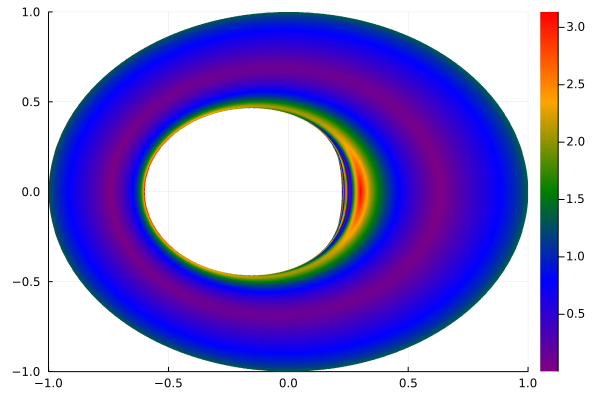

In [17]:
fig = Plots.heatmap(k2s, k3s, transpose(reshape(Z, N, N)), c=:rainbow, dpi=300)


Plots.savefig("~/Downloads/loss.png")

display(fig)
